In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from doubleml import DoubleMLData, DoubleMLPLR

# Load the dataset
df = pd.read_excel('merged_final_with_updated_features.xlsx')

# Define features (X), treatment (D), outcome (Y)
X = df.drop(columns=['crime_reach', 'transit_reach', 'id', 'Year', 'neighbors', 'longitude', 'latitude', 'neighborhood_id', 'betweenness_centrality', 'type'])
Y = df['crime_reach']
D = df['transit_reach']
groups = df['id']
groups_mixed = df['neighborhood_id']

# Normalize the features for KNN and LSTM
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create DoubleMLData object
dml_data = DoubleMLData.from_arrays(X.values, Y.values, D.values)
dml_data_knn = DoubleMLData.from_arrays(X_scaled, Y.values, D.values)

Define **KNN, RF, XGBoost**

In [11]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor

# Define the optimal hyperparameters
rf_params = {
    'n_estimators': 100,
    'max_depth': 10,
    'max_features': 'sqrt',
    'min_samples_leaf': 2,
    'min_samples_split': 10,
    'random_state': 42
}

xgb_params = {
    'n_estimators': 100,
    'max_depth': 3,
    'learning_rate': 0.1,
    'colsample_bytree': 0.8,
    'subsample': 0.9,
    'random_state': 42
}

knn_params = {
    'metric': 'manhattan',
    'n_neighbors': 22,
    'weights': 'distance'
}

**LSTM**

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.base import BaseEstimator, RegressorMixin

# Define the LSTM model
class LSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout_rate):
        super(LSTMRegressor, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

class LSTMEstimator(BaseEstimator, RegressorMixin):
    def __init__(self, input_dim, hidden_dim=200, output_dim=1, num_layers=1, dropout_rate=0.5, epochs=50, batch_size=128, learning_rate=0.001):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = LSTMRegressor(input_dim, hidden_dim, output_dim, num_layers, dropout_rate).to(self.device)
    
    def fit(self, X, y):
        X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(1).to(self.device)
        y_tensor = torch.tensor(y, dtype=torch.float32).to(self.device)
        dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        
        criterion = nn.MSELoss()
        optimizer = optim.RMSprop(self.model.parameters(), lr=self.learning_rate)
        
        self.model.train()
        for epoch in range(self.epochs):
            for batch_X, batch_y in dataloader:
                optimizer.zero_grad()
                outputs = self.model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
    
    def predict(self, X):
        self.model.eval()
        X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(1).to(self.device)
        with torch.no_grad():
            predictions = self.model(X_tensor).cpu().numpy()
        return predictions.flatten()

lstm_estimator = LSTMEstimator(input_dim=X.shape[1])

c:\Users\azizs\OneDrive\Bureau\acm_code\venv\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


**LME**

In [13]:
from statsmodels.regression.mixed_linear_model import MixedLM

# Define custom linear mixed effects learner
class LinearMixedEffectsLearner:
    def __init__(self, formula=None, groups=None):
        self.formula = formula
        self.groups = groups
        self.model = None

    def fit(self, X, y):
        data = pd.DataFrame(X, columns=[f'X{i+1}' for i in range(X.shape[1])])
        data['y'] = y
        data['groups'] = self.groups
        self.model = MixedLM.from_formula(self.formula, data, groups=data['groups']).fit()

    def predict(self, X):
        data = pd.DataFrame(X, columns=[f'X{i+1}' for i in range(X.shape[1])])
        data['groups'] = self.groups
        return self.model.predict(data)

    def set_params(self, **params):
        self.formula = params.get('formula', self.formula)
        self.groups = params.get('groups', self.groups)
        return self

    def get_params(self, deep=True):
        return {'formula': self.formula, 'groups': self.groups}

# Initialize the learners
learner_lme = LinearMixedEffectsLearner(formula='y ~ X1 + X2', groups=groups)

**Implementation**

In [8]:
results = []

# Function to perform DML with varying number of folds
def perform_dml_with_folds(folds, model, model_name, data, results):
    group_kfold = GroupKFold(n_splits=folds)
    all_smpls = [(train_idx.tolist(), test_idx.tolist()) for train_idx, test_idx in group_kfold.split(X, Y, groups=groups)]
    all_smpls = [all_smpls]
    
    # Initialize the DoubleMLPLR model with the specified learner
    dml_plr = DoubleMLPLR(data, ml_g=model, ml_m=model, ml_l=model, n_folds=folds, n_rep=1)
    dml_plr.set_sample_splitting(all_smpls)
    dml_plr.fit()
    
    # Collect the results
    result = {
        'model': model_name,
        'folds': folds,
        'theta': dml_plr.coef[0],
        'se': dml_plr.se[0],
        'rmses_g': float(dml_plr.rmses['ml_l'][0][0]),
        'rmses_m': float(dml_plr.rmses['ml_m'][0][0]),
        'psi': dml_plr.psi.flatten(),
        'psi_deriv': dml_plr.psi_deriv.flatten()
    }
    results.append(result)

# List of folds to test
folds_list = list(range(2, 11))

In [9]:
# Perform DML with RF for varying folds
rf_learner = RandomForestRegressor(**rf_params)
for folds in folds_list:
    perform_dml_with_folds(folds, rf_learner, 'Random Forest', dml_data, results)

# Perform DML with XGB for varying folds
xgb_learner = XGBRegressor(**xgb_params)
for folds in folds_list:
    perform_dml_with_folds(folds, xgb_learner, 'XGBoost', dml_data, results)

# Perform DML with KNN for varying folds
knn_learner = KNeighborsRegressor(**knn_params)
for folds in folds_list:
    perform_dml_with_folds(folds, knn_learner, 'KNN', dml_data_knn, results)

# Perform DML with LSTM for varying folds
for folds in folds_list:
    perform_dml_with_folds(folds, lstm_estimator, 'LSTM', dml_data_knn, results)

# Perform DML with LME for varying folds
for folds in folds_list:
    perform_dml_with_folds(folds, learner_lme, 'LME', dml_data, results)

# Convert results to DataFrame for analysis
results_df = pd.DataFrame(results)
print(results_df)

c:\Users\azizs\OneDrive\Bureau\acm_code\venv\Lib\site-packages\doubleml\plm\plr.py:122: UserWarning: A learner ml_g has been provided for score = "partialling out" but will be ignored. "A learner ml_g is not required for estimation.
  warnings.warn(('A learner ml_g has been provided for score = "partialling out" but will be ignored. "'
c:\Users\azizs\OneDrive\Bureau\acm_code\venv\Lib\site-packages\doubleml\plm\plr.py:122: UserWarning: A learner ml_g has been provided for score = "partialling out" but will be ignored. "A learner ml_g is not required for estimation.
  warnings.warn(('A learner ml_g has been provided for score = "partialling out" but will be ignored. "'
c:\Users\azizs\OneDrive\Bureau\acm_code\venv\Lib\site-packages\doubleml\plm\plr.py:122: UserWarning: A learner ml_g has been provided for score = "partialling out" but will be ignored. "A learner ml_g is not required for estimation.
  warnings.warn(('A learner ml_g has been provided for score = "partialling out" but will b

            model  folds     theta        se   rmses_g   rmses_m  \
0   Random Forest      2  0.034701  0.006442  0.039291  0.036193   
1   Random Forest      3  0.022478  0.005851  0.037822  0.034350   
2   Random Forest      4  0.018377  0.005981  0.038011  0.034525   
3   Random Forest      5  0.044022  0.005421  0.037629  0.033967   
4   Random Forest      6  0.029172  0.005693  0.037607  0.033869   
5   Random Forest      7  0.036157  0.005837  0.037807  0.033611   
6   Random Forest      8  0.030021  0.005379  0.037300  0.033650   
7   Random Forest      9  0.030556  0.005296  0.037420  0.033692   
8   Random Forest     10  0.036853  0.005398  0.037433  0.033903   
9         XGBoost      2  0.014568  0.005529  0.042103  0.040931   
10        XGBoost      3  0.013640  0.005134  0.041091  0.040379   
11        XGBoost      4  0.000064  0.005416  0.041622  0.040477   
12        XGBoost      5  0.014328  0.005008  0.041123  0.040240   
13        XGBoost      6  0.005978  0.005102  0.

c:\Users\azizs\OneDrive\Bureau\acm_code\venv\Lib\site-packages\doubleml\double_ml.py:870: UserWarning: Learner provided for ml_m is probably invalid: <__main__.LinearMixedEffectsLearner object at 0x0000025B9260DC50> is (probably) neither a regressor nor a classifier. Method predict is used for prediction.
  warnings.warn(warn_msg_prefix + f'{str(learner)} is (probably) neither a regressor nor a classifier. ' +


In [ ]:
results_df.to_excel("results_dml_five_models.xlsx")

In [50]:
import pandas as pd
import numpy as np

dml_results = pd.read_excel("results_dml_five_models.xlsx")
dml_results.head()

,Unnamed: 0,model,folds,theta,se,rmses_g,rmses_m,psi,psi_deriv
0,0,Random Forest,2,0.034701,0.006442,0.039291,0.036193,[ 6.92988564e-05 4.93005921e-05 4.91102536e-...,[-5.94890585e-05 -4.47865114e-05 -4.48661350e-...
1,1,Random Forest,3,0.022478,0.005851,0.037822,0.034350,[ 4.58918179e-05 4.23224068e-05 4.11338867e-...,[-1.80000221e-05 -1.69326478e-05 -1.69217825e-...
2,2,Random Forest,4,0.018377,0.005981,0.038011,0.034525,[ 4.02279425e-05 2.31912215e-05 2.31127089e-...,[-3.27273269e-05 -3.21856623e-05 -3.19033432e-...
3,3,Random Forest,5,0.044022,0.005421,0.037629,0.033967,[ 1.34929005e-05 1.39236576e-05 1.41463595e-...,[-2.62660838e-05 -2.64004895e-05 -2.64004895e-...
4,4,Random Forest,6,0.029172,0.005693,0.037607,0.033869,[ 2.84821345e-05 1.80498069e-05 1.54903681e-...,[-1.12514399e-05 -5.53121792e-06 -4.56927881e-...


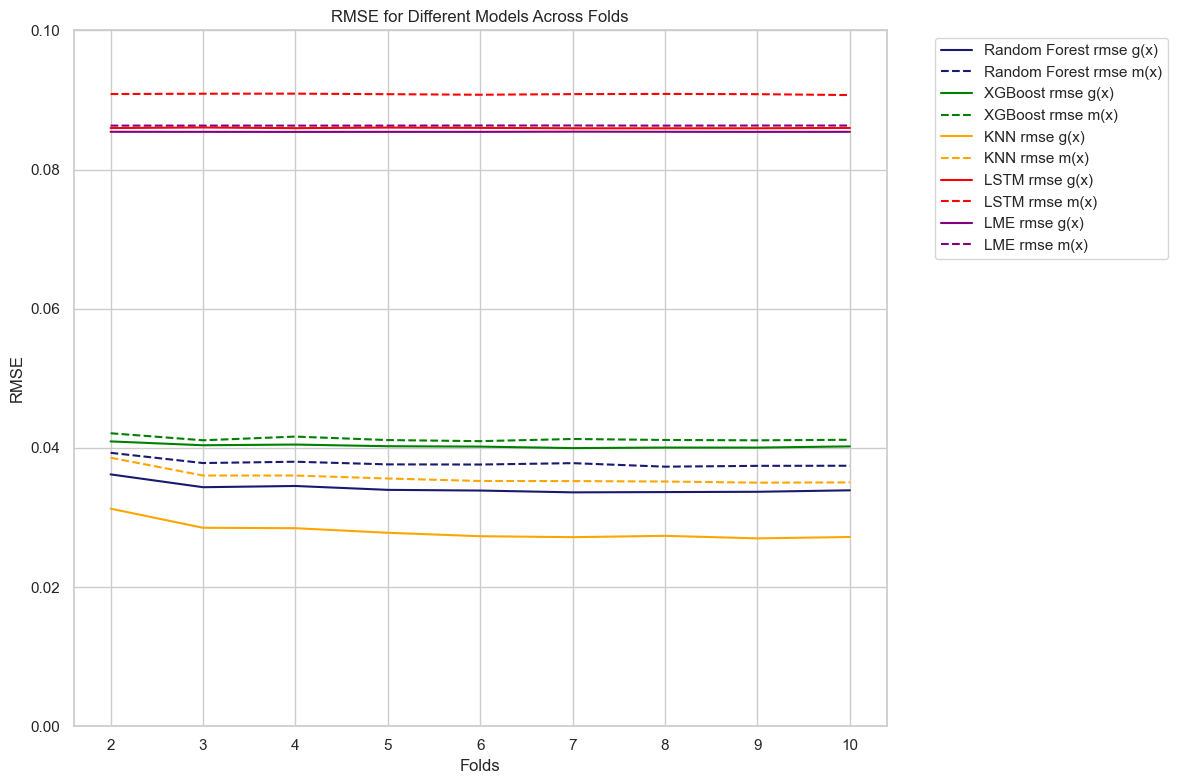

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define colors for each model
colors = {
    'Random Forest': 'midnightblue',
    'XGBoost': 'green',
    'KNN': 'orange',
    'LSTM': 'red',
    'LME': 'purple'
}

# Set style
sns.set(style="whitegrid")

# Plotting
plt.figure(figsize=(12, 8))

for model in dml_results['model'].unique():
    model_data = dml_results[dml_results['model'] == model]
    sns.lineplot(x='folds', y='rmses_m', data=model_data, label=f'{model} rmse g(x)', color=colors[model])
    sns.lineplot(x='folds', y='rmses_g', data=model_data, label=f'{model} rmse m(x)', linestyle='--', color=colors[model])

# Y-axis scale
plt.ylim(0, 0.1)

# Adding labels and title
plt.xlabel('Folds')
plt.ylabel('RMSE')
plt.title('RMSE for Different Models Across Folds')

# Adding legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.tight_layout()
plt.show()

C:\Users\azizs\AppData\Local\Temp\ipykernel_195168\1718373200.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fold_9_data['model'] = pd.Categorical(fold_9_data['model'], categories=model_order, ordered=True)
C:\Users\azizs\AppData\Local\Temp\ipykernel_195168\1718373200.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='model', y='theta', data=fold_9_data, ax=ax1, palette=colors)


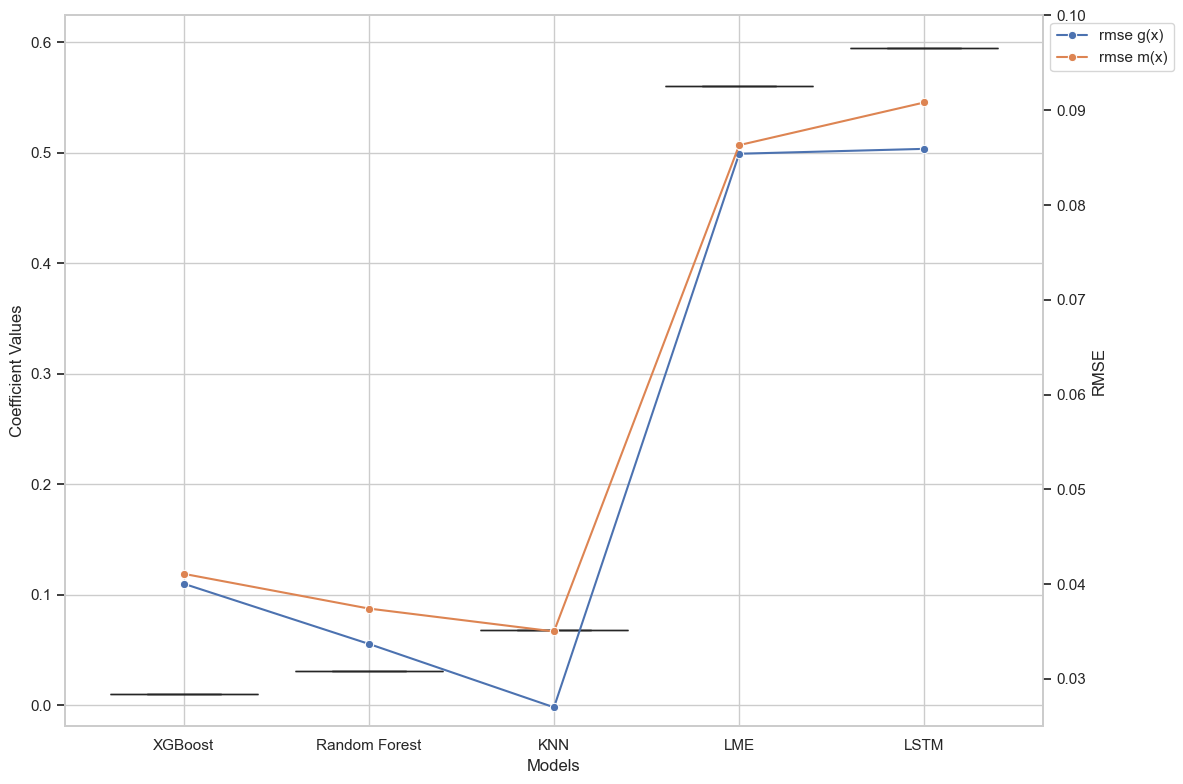

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure the order of the models
model_order = ['XGBoost', 'Random Forest', 'KNN', 'LME', 'LSTM']

# Filter the data to only include fold 9
fold_9_data = dml_results[dml_results['folds'] == 9]

# Convert the 'model' column to a categorical type with the specified order
fold_9_data['model'] = pd.Categorical(fold_9_data['model'], categories=model_order, ordered=True)

# Define colors for each model
colors = {
    'Random Forest': 'midnightblue',
    'XGBoost': 'green',
    'KNN': 'orange',
    'LSTM': 'red',
    'LME': 'purple'
}

# Set style
sns.set(style="whitegrid")

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(12, 8))

# Boxplot for coefficients with specified order
sns.boxplot(x='model', y='theta', data=fold_9_data, ax=ax1, palette=colors)
ax1.set_ylabel('Coefficient Values')
ax1.set_xlabel('Models')

# Adding grid lines for the primary y-axis
ax1.yaxis.grid(True)
ax1.xaxis.grid(True)

# Create secondary y-axis
ax2 = ax1.twinx()

# Plotting RMSE values for fold 9 with specified order
sns.lineplot(x='model', y='rmses_m', data=fold_9_data, marker='o', label='rmse g(x)', ax=ax2)
sns.lineplot(x='model', y='rmses_g', data=fold_9_data, marker='o', label='rmse m(x)', ax=ax2)

# Remove horizontal grid lines related to the secondary axis
ax2.grid(False)

# Y-axis scale for secondary axis
ax2.set_ylim(0.025, 0.1)
ax2.set_ylabel('RMSE')

# Adding legend outside the plot
ax2.legend(bbox_to_anchor=(1, 1), loc='upper left')

# Display the plot
plt.tight_layout()
plt.show()

C:\Users\azizs\AppData\Local\Temp\ipykernel_195168\602168688.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='model', y='theta', data=dml_results, palette=colors, ax=ax1)


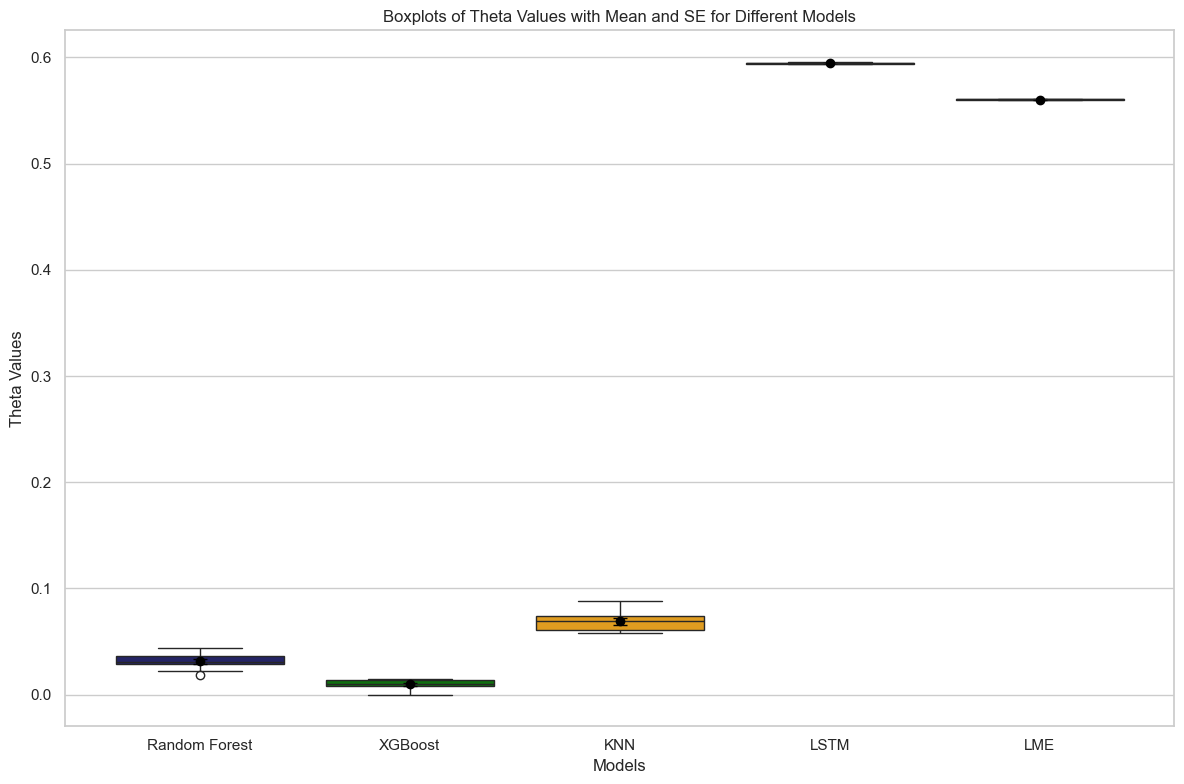

In [5]:
# Define colors for each model
colors = {
    'Random Forest': 'midnightblue',
    'XGBoost': 'green',
    'KNN': 'orange',
    'LSTM': 'red',
    'LME': 'purple'
}

# Calculate mean and SE for each model
summary_stats = dml_results.groupby('model')['theta'].agg(['mean', 'sem']).reset_index()
summary_stats.columns = ['model', 'mean_theta', 'se_theta']

# Set style
sns.set(style="whitegrid")

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(12, 8))

# Boxplot for theta values
sns.boxplot(x='model', y='theta', data=dml_results, palette=colors, ax=ax1)

# Plot mean and SE
for index, row in summary_stats.iterrows():
    ax1.errorbar(row['model'], row['mean_theta'], yerr=row['se_theta'], fmt='o', color='black', capsize=5)

# Adding labels and title
ax1.set_xlabel('Models')
ax1.set_ylabel('Theta Values')
plt.title('Boxplots of Theta Values with Mean and SE for Different Models')

# Display the plot
plt.tight_layout()
plt.show()

In [61]:
# Initialize the learners
learner_rf = RandomForestRegressor(**rf_params)
learner_xgb = XGBRegressor(**xgb_params)
learner_knn = KNeighborsRegressor(**knn_params)
learner_lstm = lstm_estimator
learner_lme = LinearMixedEffectsLearner(formula='y ~ X1 + X2', groups=groups_mixed)

# Cross-fitting configuration
n_folds = 9
group_kfold = GroupKFold(n_splits=n_folds)
all_smpls = [(train_idx.tolist(), test_idx.tolist()) for train_idx, test_idx in group_kfold.split(X, Y, groups=groups)]
all_smpls = [all_smpls]

# Fit DML models for each learner
learners = {
    'Random Forest': (learner_rf, dml_data),
    'XGBoost': (learner_xgb, dml_data),
    'KNN': (learner_knn, dml_data_knn),
    'LSTM': (learner_lstm, dml_data_knn),
    'LME': (learner_lme, dml_data)
}

dml_results = {}

for name, (learner, dml_data_obj) in learners.items():
    dml_plr = DoubleMLPLR(dml_data_obj, ml_l=learner, ml_g=learner, ml_m=learner, n_folds=n_folds, n_rep=1)
    dml_plr.set_sample_splitting(all_smpls)
    dml_plr.fit()
    dml_results[name] = dml_plr
    print(f'{name} DML PLR Results:')
    print(dml_plr)

c:\Users\azizs\OneDrive\Bureau\acm_code\venv\Lib\site-packages\doubleml\plm\plr.py:122: UserWarning: A learner ml_g has been provided for score = "partialling out" but will be ignored. "A learner ml_g is not required for estimation.
  warnings.warn(('A learner ml_g has been provided for score = "partialling out" but will be ignored. "'


Random Forest DML PLR Results:
================== DoubleMLPLR Object ==================

------------------ Data summary      ------------------
Outcome variable: y
Treatment variable(s): ['d']
Covariates: ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18']
Instrument variable(s): None
No. Observations: 98864

------------------ Score & algorithm ------------------
Score function: partialling out

------------------ Machine learner   ------------------
Learner ml_l: RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=10, random_state=42)
Learner ml_m: RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=10, random_state=42)
Out-of-sample Performance:
Learner ml_l RMSE: [[0.03742005]]
Learner ml_m RMSE: [[0.0336917]]

------------------ Resampling        ------------------
No. folds: 9
No. repea

c:\Users\azizs\OneDrive\Bureau\acm_code\venv\Lib\site-packages\doubleml\plm\plr.py:122: UserWarning: A learner ml_g has been provided for score = "partialling out" but will be ignored. "A learner ml_g is not required for estimation.
  warnings.warn(('A learner ml_g has been provided for score = "partialling out" but will be ignored. "'


XGBoost DML PLR Results:
================== DoubleMLPLR Object ==================

------------------ Data summary      ------------------
Outcome variable: y
Treatment variable(s): ['d']
Covariates: ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18']
Instrument variable(s): None
No. Observations: 98864

------------------ Score & algorithm ------------------
Score function: partialling out

------------------ Machine learner   ------------------
Learner ml_l: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=

c:\Users\azizs\OneDrive\Bureau\acm_code\venv\Lib\site-packages\doubleml\plm\plr.py:122: UserWarning: A learner ml_g has been provided for score = "partialling out" but will be ignored. "A learner ml_g is not required for estimation.
  warnings.warn(('A learner ml_g has been provided for score = "partialling out" but will be ignored. "'


KNN DML PLR Results:
================== DoubleMLPLR Object ==================

------------------ Data summary      ------------------
Outcome variable: y
Treatment variable(s): ['d']
Covariates: ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18']
Instrument variable(s): None
No. Observations: 98864

------------------ Score & algorithm ------------------
Score function: partialling out

------------------ Machine learner   ------------------
Learner ml_l: KNeighborsRegressor(metric='manhattan', n_neighbors=22, weights='distance')
Learner ml_m: KNeighborsRegressor(metric='manhattan', n_neighbors=22, weights='distance')
Out-of-sample Performance:
Learner ml_l RMSE: [[0.03500384]]
Learner ml_m RMSE: [[0.0269981]]

------------------ Resampling        ------------------
No. folds: 9
No. repeated sample splits: 1

------------------ Fit summary       ------------------
       coef   std err       t         P>|t|     2.5 %   

c:\Users\azizs\OneDrive\Bureau\acm_code\venv\Lib\site-packages\doubleml\plm\plr.py:122: UserWarning: A learner ml_g has been provided for score = "partialling out" but will be ignored. "A learner ml_g is not required for estimation.
  warnings.warn(('A learner ml_g has been provided for score = "partialling out" but will be ignored. "'
c:\Users\azizs\OneDrive\Bureau\acm_code\venv\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
c:\Users\azizs\OneDrive\Bureau\acm_code\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, 

LSTM DML PLR Results:
================== DoubleMLPLR Object ==================

------------------ Data summary      ------------------
Outcome variable: y
Treatment variable(s): ['d']
Covariates: ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18']
Instrument variable(s): None
No. Observations: 98864

------------------ Score & algorithm ------------------
Score function: partialling out

------------------ Machine learner   ------------------
Learner ml_l: LSTMEstimator(input_dim=18)
Learner ml_m: LSTMEstimator(input_dim=18)
Out-of-sample Performance:
Learner ml_l RMSE: [[0.09084745]]
Learner ml_m RMSE: [[0.08599432]]

------------------ Resampling        ------------------
No. folds: 9
No. repeated sample splits: 1

------------------ Fit summary       ------------------
       coef   std err          t  P>|t|    2.5 %    97.5 %
d  0.595217  0.007105  83.769229    0.0  0.58129  0.609143


c:\Users\azizs\OneDrive\Bureau\acm_code\venv\Lib\site-packages\doubleml\double_ml.py:880: UserWarning: Learner provided for ml_l is probably invalid: <__main__.LinearMixedEffectsLearner object at 0x00000146466F09D0> is (probably) no regressor.
  warnings.warn(warn_msg_prefix + f'{str(learner)} is (probably) no regressor.')
c:\Users\azizs\OneDrive\Bureau\acm_code\venv\Lib\site-packages\doubleml\double_ml.py:870: UserWarning: Learner provided for ml_m is probably invalid: <__main__.LinearMixedEffectsLearner object at 0x00000146466F09D0> is (probably) neither a regressor nor a classifier. Method predict is used for prediction.
  warnings.warn(warn_msg_prefix + f'{str(learner)} is (probably) neither a regressor nor a classifier. ' +
c:\Users\azizs\OneDrive\Bureau\acm_code\venv\Lib\site-packages\doubleml\plm\plr.py:122: UserWarning: A learner ml_g has been provided for score = "partialling out" but will be ignored. "A learner ml_g is not required for estimation.
  warnings.warn(('A learner 

LME DML PLR Results:
================== DoubleMLPLR Object ==================

------------------ Data summary      ------------------
Outcome variable: y
Treatment variable(s): ['d']
Covariates: ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18']
Instrument variable(s): None
No. Observations: 98864

------------------ Score & algorithm ------------------
Score function: partialling out

------------------ Machine learner   ------------------
Learner ml_l: <__main__.LinearMixedEffectsLearner object at 0x00000146466F09D0>
Learner ml_m: <__main__.LinearMixedEffectsLearner object at 0x00000146466F09D0>
Out-of-sample Performance:
Learner ml_l RMSE: [[0.08646587]]
Learner ml_m RMSE: [[0.0855598]]

------------------ Resampling        ------------------
No. folds: 9
No. repeated sample splits: 1

------------------ Fit summary       ------------------
       coef   std err          t  P>|t|   2.5 %    97.5 %
d  0.561307  0.006

c:\Users\azizs\OneDrive\Bureau\acm_code\venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\azizs\OneDrive\Bureau\acm_code\venv\Lib\site-packages\doubleml\double_ml.py:870: UserWarning: Learner provided for ml_m is probably invalid: <__main__.LinearMixedEffectsLearner object at 0x00000146466F09D0> is (probably) neither a regressor nor a classifier. Method predict is used for prediction.
  warnings.warn(warn_msg_prefix + f'{str(learner)} is (probably) neither a regressor nor a classifier. ' +


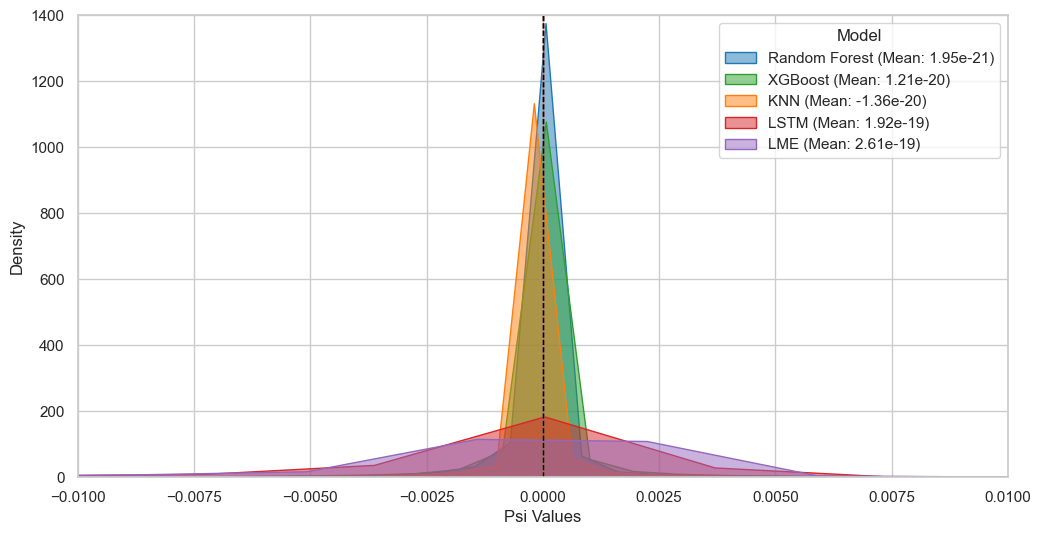

In [64]:
# Define colors for each model
colors = {
    'Random Forest': 'tab:blue',
    'XGBoost': 'tab:green',
    'KNN': 'tab:orange',
    'LSTM': 'tab:red',
    'LME': 'tab:purple'
}

# Extract psi values and create DataFrame for density plot
psi_dfs = []
for model_name in dml_results.keys():
    psi_values = dml_results[model_name].psi.flatten()
    psi_df = pd.DataFrame({'Psi': psi_values, 'Model': [model_name] * len(psi_values)})
    psi_dfs.append(psi_df)

df_psi = pd.concat(psi_dfs, ignore_index=True)

# Calculate means of Psi values
means = df_psi.groupby('Model')['Psi'].mean()

# Plot
plt.figure(figsize=(12, 6))

# Plot density
for model_name, color in colors.items():
    sns.kdeplot(data=df_psi[df_psi['Model'] == model_name], x='Psi', fill=True, common_norm=False, alpha=0.5, 
                label=f'{model_name} (Mean: {means[model_name]:.2e})', color=color)

# Add dashed lines for the means
for model_name, color in colors.items():
    plt.axvline(means[model_name], color=color, linestyle='--', linewidth=1)

plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.ylim(0, 1400)
plt.xlim(-0.01, 0.01)
plt.xlabel('Psi Values')
plt.ylabel('Density')
plt.legend(title='Model')
plt.grid(True)
plt.show()

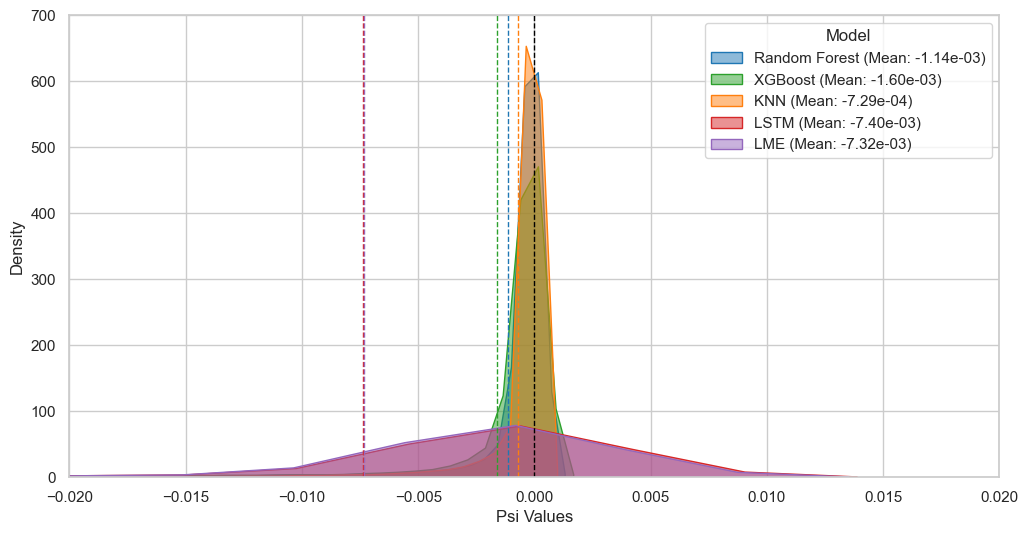

In [63]:
# Define colors for each model
colors = {
    'Random Forest': 'tab:blue',
    'XGBoost': 'tab:green',
    'KNN': 'tab:orange',
    'LSTM': 'tab:red',
    'LME': 'tab:purple'
}

# Extract psi values and create DataFrame for density plot
psi_dfs = []
for model_name in dml_results.keys():
    psi_values = dml_results[model_name].psi_deriv.flatten()
    psi_df = pd.DataFrame({'Psi': psi_values, 'Model': [model_name] * len(psi_values)})
    psi_dfs.append(psi_df)

df_psi = pd.concat(psi_dfs, ignore_index=True)

# Calculate means of Psi values
means = df_psi.groupby('Model')['Psi'].mean()

# Plot
plt.figure(figsize=(12, 6))

# Plot density
for model_name, color in colors.items():
    sns.kdeplot(data=df_psi[df_psi['Model'] == model_name], x='Psi', fill=True, common_norm=False, alpha=0.5, 
                label=f'{model_name} (Mean: {means[model_name]:.2e})', color=color)

# Add dashed lines for the means
for model_name, color in colors.items():
    plt.axvline(means[model_name], color=color, linestyle='--', linewidth=1)

plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.ylim(0, 700)
plt.xlim(-0.02, 0.02)
plt.xlabel('Psi Values')
plt.ylabel('Density')
plt.legend(title='Model')
plt.grid(True)
plt.show()

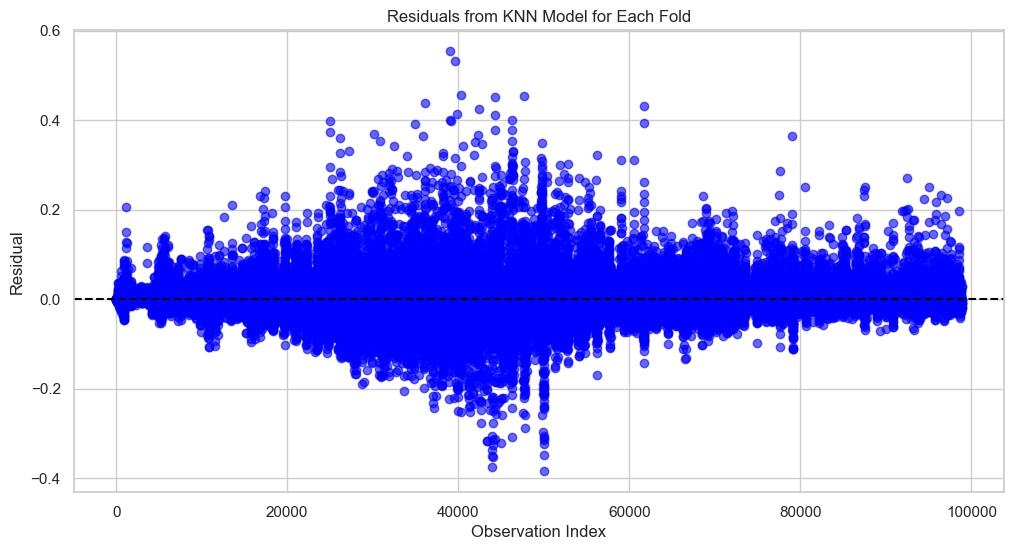

In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_excel('merged_final_with_updated_features.xlsx')

# Define features (X), treatment (D), outcome (Y)
X = df.drop(columns=['crime_reach', 'transit_reach', 'id', 'Year', 'neighbors', 'longitude', 'latitude', 'neighborhood_id', 'betweenness_centrality', 'type'])
Y = df['crime_reach']
groups = df['id']

# Normalize the features for KNN
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define the KNN model with optimal hyperparameters
knn_params = {
    'metric': 'manhattan',
    'n_neighbors': 22,
    'weights': 'distance'
}
knn = KNeighborsRegressor(**knn_params)

# Set up GroupKFold
n_folds = 9
group_kfold = GroupKFold(n_splits=n_folds)

# Initialize a list to store residuals and their corresponding observation indices
residuals = []
observations = []

# Perform the cross-validation
for fold, (train_idx, test_idx) in enumerate(group_kfold.split(X_scaled, Y, groups=groups)):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    Y_train, Y_test = Y[train_idx], Y[test_idx]
    
    # Train the KNN model
    knn.fit(X_train, Y_train)
    
    # Predict on the test set
    Y_pred = knn.predict(X_test)
    
    # Calculate residuals
    fold_residuals = Y_test - Y_pred
    
    # Store the residuals and their corresponding observation indices
    residuals.extend(fold_residuals)
    observations.extend(test_idx)

# Create a DataFrame to store the residuals and their corresponding observation indices
residuals_df = pd.DataFrame({'Observation': observations, 'Residual': residuals})

# Plot the residuals
plt.figure(figsize=(12, 6))
plt.scatter(residuals_df['Observation'], residuals_df['Residual'], alpha=0.6, color='blue')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Observation Index')
plt.ylabel('Residual')
plt.title('Residuals from KNN Model for Each Fold')
plt.grid(True)
plt.show()

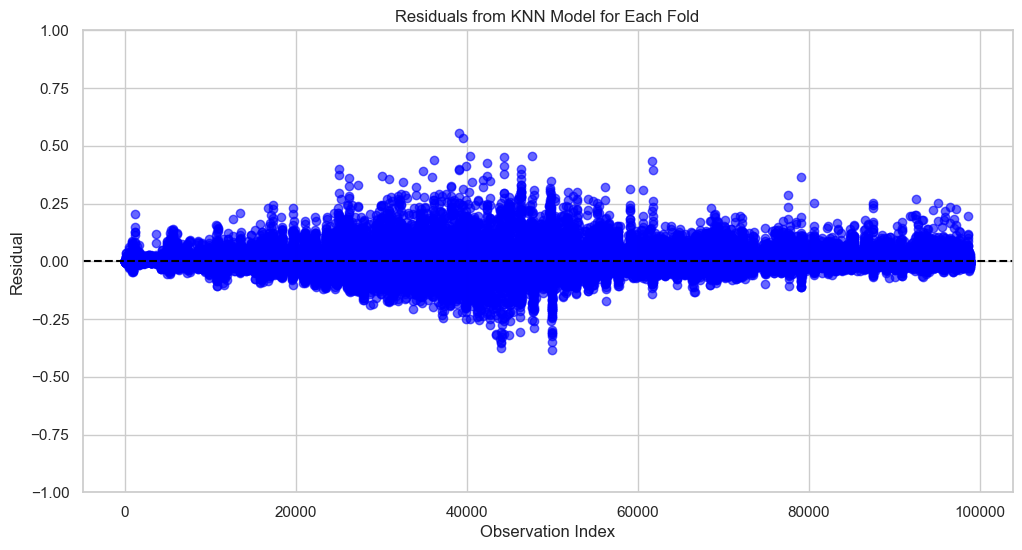

In [33]:
# Plot the residuals
plt.figure(figsize=(12, 6))
plt.scatter(residuals_df['Observation'], residuals_df['Residual'], alpha=0.6, color='blue')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Observation Index')
plt.ylabel('Residual')
plt.ylim(-1,1)
plt.title('Residuals from KNN Model for Each Fold')
plt.grid(True)
plt.show()

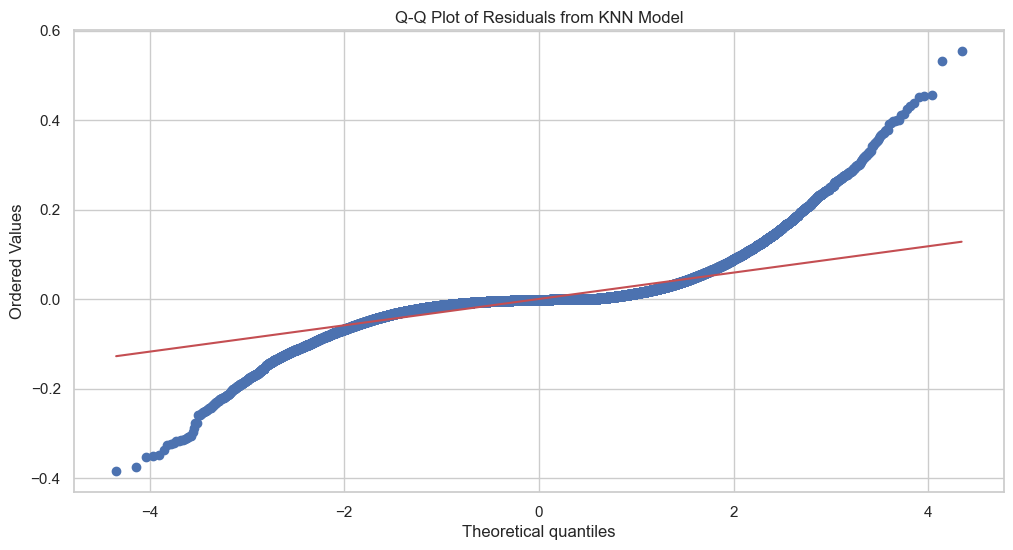

In [35]:
import scipy.stats as stats

# Generate Q-Q plot
plt.figure(figsize=(12, 6))
stats.probplot(residuals_df['Residual'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals from KNN Model')
plt.grid(True)
plt.show()

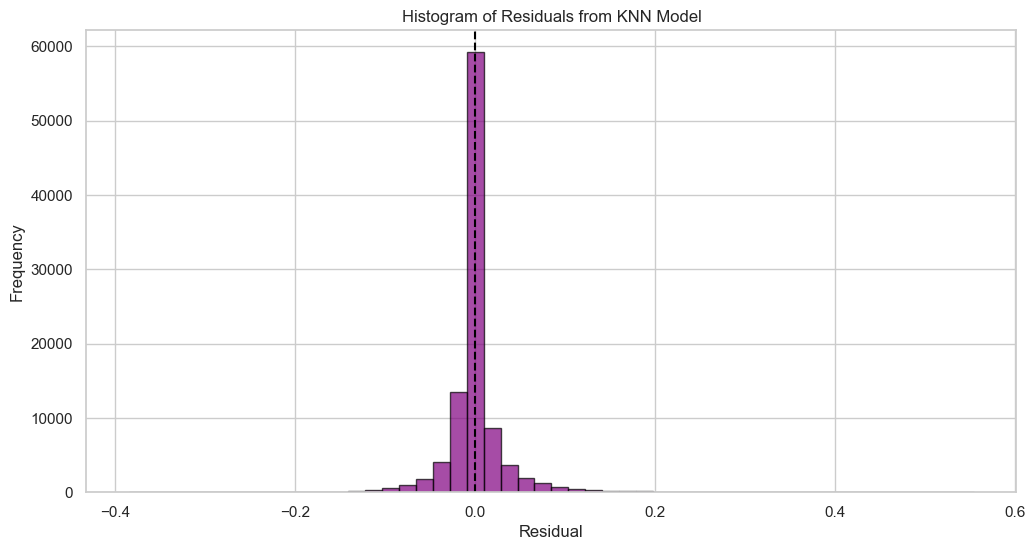

In [47]:
# Generate histogram of residuals
plt.figure(figsize=(12, 6))
plt.hist(residuals_df['Residual'], bins=50, color='purple', edgecolor='black', alpha=0.7)
plt.axvline(0, color='black', linestyle='--')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals from KNN Model')
plt.grid(True)
plt.show()

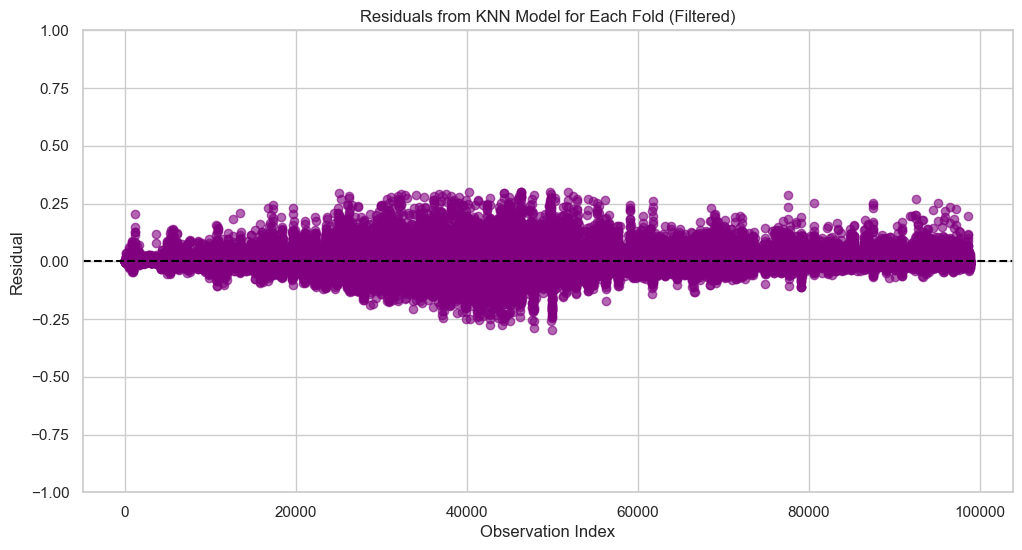

In [46]:
import matplotlib.pyplot as plt

# Filter residuals within the range of -0.26 and 0.26
filtered_residuals_df = residuals_df[(residuals_df['Residual'] >= -0.3) & (residuals_df['Residual'] <= 0.3)]

# Plot the filtered residuals
plt.figure(figsize=(12, 6))
plt.scatter(filtered_residuals_df['Observation'], filtered_residuals_df['Residual'], alpha=0.6, color='purple')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Observation Index')
plt.ylabel('Residual')
plt.ylim(-1, 1)
plt.title('Residuals from KNN Model for Each Fold (Filtered)')
plt.grid(True)
plt.show()